# Text mining 

* Identificar las palabras empleadas por reconocidos usuarios de twitter.

* Crear un modelo de machine learning capaz de clasificar la autoría de las publicaciones en base a su texto.

* Análisis de sentimientos.


# Extracción datos Twitter

Como ocurre en muchas redes sociales, la propia plataforma pone a disposición de los usuarios una API que permite extraer información. Aunque en la mayoría de casos se trata de web services API, con frecuencia existen librerías que permiten interactuar con la API desde diversos lenguajes de programación. Un ejemplo de ello es Tweepy, un wrapper de Python que se comunica con la API de Twitter.

Debido a que estas APIs se actualizan con relativa frecuencia, y para evitar que el documento deje de mostrar código funcional, se emplean tweets ya extraídos y que pueden encontrarse en el repositorio de github. Los tweets pertenecen a:

Elon Musk (@elonmusk) y Bill Gates (@BillGates), dos directivos de empresas tecnológicas.

Mayor Ed Lee (@mayoredlee) alcalde de la ciudad de San Francisco.


In [1]:
# Tratamiento de datos

import numpy as np
import pandas as pd
import string
import re
'''
Una expresión regular (o RE, por sus siglas en inglés) especifica un conjunto
de cadenas que coinciden con ella; las funciones de este módulo permiten comprobar
si una determinada cadena coincide con una expresión regular dada.
https://docs.python.org/es/3/library/re.html

'''
# Gráficos

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado

from sklearn import svm # clasificador support vector machines
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
# cambiador de formatos para factorizar un dataset
from sklearn.feature_extraction.text import TfidfVectorizer 

# Configuración warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
!{sys.executable} -m pip install nltk

In [3]:
import nltk # natural lenguaje tool kit para procesamiento de lenguaje natural
nltk.download('stopwords')
from nltk.corpus import stopwords # palabras conectoras que repetimos con frecuencia en un idioma


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joseb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Datos
para el ejemplo se utiliza una base de datos de tweets recopilados de las 3 personas en 2017

In [4]:
# Lectura de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-con-R/master/datos/'
tweets_elon   = pd.read_csv(url + "datos_tweets_@elonmusk.csv")
tweets_edlee  = pd.read_csv(url + "datos_tweets_@mayoredlee.csv")
tweets_bgates = pd.read_csv(url + "datos_tweets_@BillGates.csv")

print('Número de tweets @BillGates: ' + str(tweets_bgates.shape[0]))
print('Número de tweets @mayoredlee: ' + str(tweets_edlee.shape[0]))
print('Número de tweets @elonmusk: ' + str(tweets_elon.shape[0]))

Número de tweets @BillGates: 2087
Número de tweets @mayoredlee: 2447
Número de tweets @elonmusk: 2678


In [5]:
from IPython.core.display import HTML

# Se unen los tres dataframes en uno solo
tweets = pd.concat([tweets_elon, tweets_edlee, tweets_bgates], ignore_index=True)

# Se seleccionan y renombran las columnas de interés
tweets = tweets[['screen_name', 'created_at', 'status_id', 'text']]
tweets.columns = ['autor', 'fecha', 'id', 'texto']

# Parseo de fechas
tweets['fecha'] = pd.to_datetime(tweets['fecha'])
#tweets.head(3)
display(HTML(tweets.to_html()))

,autor,fecha,id,texto
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,"""If one day, my words are against science, choose science.""\nMustafa Kemal Atatürk"
1,elonmusk,2017-11-09 17:12:46+00:00,9.286717e+17,I placed the flowers\n\nThree broken ribs\nA pierced lung\nAnd still he fought\nFor peace at… https://t.co/MeEKf2ZntM
2,elonmusk,2017-11-08 18:55:13+00:00,9.283351e+17,Atatürk Anıtkabir https://t.co/al3wt0njr6
3,elonmusk,2017-11-07 19:48:45+00:00,9.279862e+17,"@Bob_Richards One rocket, slightly toasted"
4,elonmusk,2017-10-28 21:36:18+00:00,9.243894e+17,@uncover007 500 ft so far. Should be 2 miles long in three or four months and hopefully stretch the whole 405 N-S c… https://t.co/BfoqYKJg3u
5,elonmusk,2017-10-28 21:30:41+00:00,9.243880e+17,Picture of The Boring Company LA tunnel taken yesterday https://t.co/TfdVKyXFsJ
6,elonmusk,2017-10-26 21:10:00+00:00,9.236580e+17,"Btw, just want to express a word of appreciation for the hard work of the Tesla Gigafactory team. Reason I camped o… https://t.co/Nztp84BSLW"
7,elonmusk,2017-10-26 15:45:39+00:00,9.235764e+17,"Whiskey, fire, s’mores and JC\n\nAlso, hotdog or not hotdog? https://t.co/86cxwbZyWB"
8,elonmusk,2017-10-26 08:39:27+00:00,9.234691e+17,Campfire on the Gigafactory roof https://t.co/JKxaKUzvZY
9,elonmusk,2017-10-26 00:06:11+00:00,9.233399e+17,Just feed it The Godfather movies as input. What’s the worst that could happen? https://t.co/WX4Kx45csv


### Distribución temporal de los tweets


Dado que cada usuario puede haber iniciado su actividad en Twitter en diferente momento, es interesante explorar si los tweets recuperados comparten el mismo tiempo.


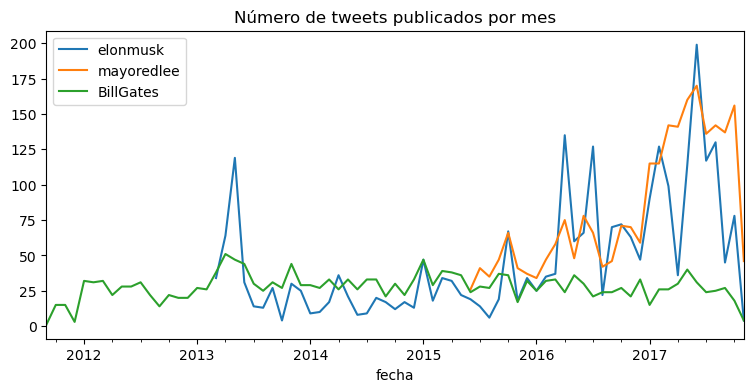

In [6]:
# Distribución temporal de los tweets

fig, ax = plt.subplots(figsize=(9,4))

for autor in tweets.autor.unique():
#en la columna autor busca y ejecuta el loop teniendo como contador cada unico posible autor
    df_temp = tweets[tweets['autor'] == autor].copy()
    #crea un marco de datos temporal 'df_temp' que contiene sólo los tweets del autor actual.

    df_temp['fecha'] = pd.to_datetime(df_temp['fecha'].dt.strftime('%Y-%m'))
#convierte la columna 'fecha' de 'df_temp' en un objeto datetime con el formato '%Y-%m' (año-mes).
    
    df_temp = df_temp.groupby(df_temp['fecha']).size()
#agrupa el marco de datos 'df_temp' por la columna 'fecha' y cuenta el número de tweets de cada 
# mes.
    
    df_temp.plot(label=autor, ax=ax)
# Esta línea traza el número de tweets de cada mes en el objeto de eje actual 'ax' y etiqueta 
#el gráfico con el nombre del autor.
ax.set_title('Número de tweets publicados por mes')
ax.legend(); # poner ; al final de una isntruccion hace que se ejecute en vez de mostrarse como output



Puede observarse un perfil de actividad distinto para cada usuario. Bill Gates ha mantenido una actividad constante de en torno a 30 tweets por mes durante todo el periodo estudiado. Elon Musk muestra una actividad inicial por debajo de la de Bill Gates pero, a partir de febrero de 2016, incrementó notablemente el número de tweets publicados. Ed Lee tiene una actividad muy alta sobre todo en el periodo 2017. Debido a las limitaciones que impone Twitter en las recuperaciones, cuanto más activo es un usuario, menor es el intervalo de tiempo para el que se recuperan tweets. En el caso de Ed Lee, dado que publica con mucha más frecuencia que el resto, con la misma cantidad de tweets recuperados se abarca menos de la mitad del rango temporal que con los otros.

# Limpieza y Tokenización


El proceso de limpieza de texto, dentro del ámbito de text mining, consiste en eliminar del texto todo aquello que no aporte información sobre su temática, estructura o contenido. No existe una única forma de hacerlo, depende en gran medida de la finalidad del análisis y de la fuente de la que proceda el texto. Por ejemplo, en las redes sociales, los usuarios pueden escribir de la forma que quieran, lo que suele resultar en un uso elevado de abreviaturas y signos de puntuación. En este ejercicio, se procede a eliminar: patrones no informativos (urls de páginas web), signos de puntuación, etiquetas HTML, caracteres sueltos y números.

Tokenizar un texto consiste en dividir el texto en las unidades que lo conforman, entendiendo por token el elemento más sencillo con significado propio para el análisis en cuestión, en este caso, las palabras.

Existen múltiples librerías que automatizan en gran medida la limpieza y tokenización de texto, por ejemplo, la clase feature_extraction.text.CountVectorizer de Scikit Learn, nltk.tokenize o spaCy. A pesar de ello, para este ejemplo, se define una función que, si bien está menos optimizada, tiene la ventaja de poder adaptarse fácilmente dependiendo del tipo de texto analizado. (tokenizador manual y customizable)

In [7]:
print("______________________________________________________________________")
print(string.punctuation)
print(re.escape(string.punctuation))
print("______________________________________________________________________")

______________________________________________________________________
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"\#\$%\&'\(\)\*\+,\-\./:;<=>\?@\[\\\]\^_`\{\|\}\~
______________________________________________________________________


In [8]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: string.punctuation
    y re.escape(string.punctuation)
    
    print("______________________________________________________________________")
    print(string.punctuation)
    print(re.escape(string.punctuation))
    print("______________________________________________________________________")
    
    '''

    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\
    \-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

test = "Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining"
print(test)
print(limpiar_tokenizar(texto=test))

Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining
['esto', 'es', 'ejemplo', 'de', 'limpieza', 'de', 'texto', 'cienciadedatos', 'textmining']


La función limpiar_tokenizar() elimina el símbolo @ y # de las palabras a las que acompañan. En Twitter, los usuarios se identifican de esta forma, por lo que @ y # pertenecen al nombre. Aunque es importante tener en cuenta las eliminaciones del proceso de limpieza, el impacto en este caso no es demasiado alto, ya que, si un documento se caracteriza por tener la palabra #datascience, también será detectado fácilmente mediante la palabra datascience.

In [9]:
# Se aplica la función de limpieza y tokenización a cada tweet
# ==============================================================================
tweets['texto_tokenizado'] = tweets['texto'].apply(lambda x: limpiar_tokenizar(x))
tweets[['texto', 'texto_tokenizado']].head()

,texto,texto_tokenizado
0,"""If one day, my words are against science, cho...","[if, one, day, my, words, are, against, scienc..."
1,I placed the flowers\n\nThree broken ribs\nA p...,"[placed, the, flowers, three, broken, ribs, pi..."
2,Atatürk Anıtkabir https://t.co/al3wt0njr6,"[atatürk, anıtkabir]"
3,"@Bob_Richards One rocket, slightly toasted","[bob, richards, one, rocket, slightly, toasted]"
4,@uncover007 500 ft so far. Should be 2 miles l...,"[uncover, ft, so, far, should, be, miles, long..."


# Análisis 


A la hora de entender que caracteriza la escritura de cada autor, es interesante estudiar qué palabras emplea, con qué frecuencia, así como el significado de las mismas.

En Python, una de las estructuras que más facilita el análisis exploratorio es el DataFrame de Pandas, que es la estructura en la que se encuentra almacenada ahora la información de los tweets. Sin embargo, al realizar la tokenización, ha habido un cambio importante. Antes de dividir el texto, los elementos de estudio eran los tweets, y cada uno se encontraba en una fila, cumplimento así la condición de tidy data: una observación, una fila. Al realizar la tokenización, el elemento de estudio ha pasado a ser cada token (palabra), incumpliendo así la condición de tidy data. Para volver de nuevo a la estructura ideal se tiene que expandir cada lista de tokens, duplicando el valor de las otras columnas tantas veces como sea necesario. A este proceso se le conoce como expansión o unnest.

Aunque puede parecer un proceso poco eficiente (el número de filas aumenta mucho), este simple cambio facilita actividades de tipo: agrupación, contaje, gráficos...


In [10]:
# Unnest de la columna texto_tokenizado

tweets_tidy = tweets.explode(column='texto_tokenizado')
# La función explode en pandas se utiliza para transformar cada elemento
# de una lista en una fila, replicando los valores del índice.
tweets_tidy = tweets_tidy.drop(columns='texto')
tweets_tidy = tweets_tidy.rename(columns={'texto_tokenizado':'token'})
tweets_tidy.head(3)

,autor,fecha,id,token
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,if
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,one
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,day


### Frecuencia de palabras

In [11]:
# Palabras totales utilizadas por cada autor
# ==============================================================================
print('--------------------------')
print('Palabras totales por autor')
print('--------------------------')
tweets_tidy.groupby(by='autor')['token'].count()

--------------------------
Palabras totales por autor
--------------------------


autor
BillGates     31500
elonmusk      33609
mayoredlee    41878
Name: token, dtype: int64

In [12]:
# Palabras distintas utilizadas por cada autor
# ==============================================================================
print('----------------------------')
print('Palabras distintas por autor')
print('----------------------------')
tweets_tidy.groupby(by='autor')['token'].nunique()

----------------------------
Palabras distintas por autor
----------------------------


autor
BillGates     4848
elonmusk      6628
mayoredlee    5770
Name: token, dtype: int64

Aunque Elon Musk no es el que más palabras totales ha utilizado, bien porque ha publicado menos tweets o porque estos son más cortos, es el que más palabras distintas emplea.(contenido de valor)

### Longitud media de tweets

In [13]:
# Longitud media y desviación de los tweets de cada autor
# ==============================================================================
temp_df = pd.DataFrame(tweets_tidy.groupby(by = ["autor", "id"])["token"].count())
temp_df.reset_index().groupby("autor")["token"].agg(['mean', 'std'])
#el metodo agg aplica varias funciones a una misma celda o columna dentro de un pd_df

,mean,std
autor,,
BillGates,15.144231,3.347354
elonmusk,12.611257,6.933870
mayoredlee,17.170152,3.486314


El tipo de tweet de Bill Gates y Mayor Ed Lee es similar en cuanto a longitud media y desviación. Elon Musk alterna más entre tweets cortos y largos, siendo su media inferior a la de los otros dos.

### Palabras más utilizadas por autor

In [14]:
# Top 5 palabras más utilizadas por cada autor
# ==============================================================================
tweets_tidy.groupby(['autor','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('autor') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5))

autor token  count
autor                                    
BillGates  4195    BillGates   the   1178
           4271    BillGates    to   1115
           2930    BillGates    of    669
           2084    BillGates    in    590
           2207    BillGates    is    452
elonmusk   10699    elonmusk   the    983
           10816    elonmusk    to    913
           8859     elonmusk    of    638
           7801     elonmusk    is    542
           7656     elonmusk    in    476
mayoredlee 16650  mayoredlee    to   1684
           16568  mayoredlee   the   1338
           11669  mayoredlee   amp   1212
           14957  mayoredlee   our   1096
           15964  mayoredlee    sf    909

## Stop words

En la tabla anterior puede observarse que los términos más frecuentes en todos los usuarios se corresponden con artículos, preposiciones, pronombres…, en general, palabras que no aportan información relevante sobre el texto. Estas palabras se conocen como stopwords. Para cada idioma existen distintos listados de stopwords, además, dependiendo del contexto, puede ser necesario adaptar el listado. Por ejemplo, en la tabla anterior aparece el término amp que procede de la etiqueta html &amp. Con frecuencia, a medida que se realiza un análisis se encuentran palabras que deben incluirse en el listado de stopwords.

In [15]:
# Obtención de listado de stopwords del inglés
# ==============================================================================
stop_words = list(stopwords.words('english'))
# Se añade la stoprword: amp, xa, xe
stop_words.extend(("amp", "xa", "xe"))
print(stop_words[:100])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once']


In [16]:
# Filtrado para excluir stopwords
# ==============================================================================
tweets_tidy = tweets_tidy[~(tweets_tidy["token"].isin(stop_words))]
'''
~(tweets_tidy["token"].isin(stop_words)): aplica el operador bitwise NOT (~) 
al resultado del método isin. Esto invierte los valores booleanos,
de modo que True se convierte en False y viceversa. 
Esto significa que las filas en las que el símbolo es un stopword 
tendrán ahora valores falsos, y las filas en las que el símbolo no es un stopword
tendrán valores verdaderos.
'''
print()




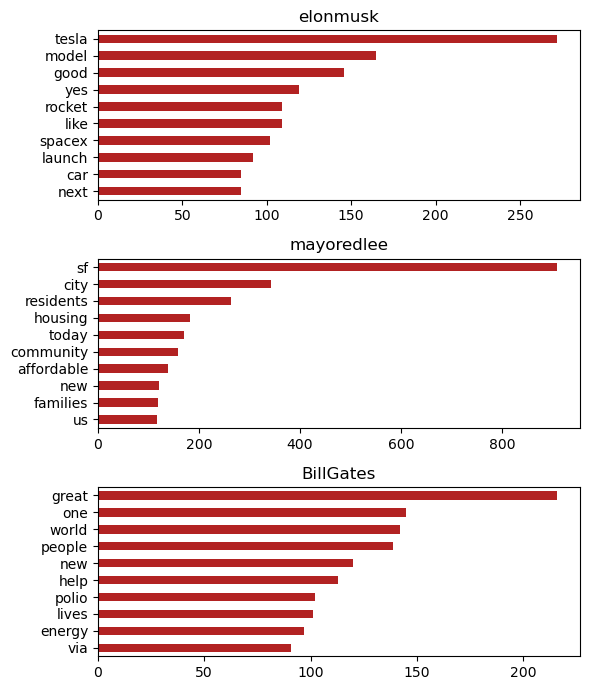

In [17]:
# Top 10 palabras por autor (sin stopwords)
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1,figsize=(6, 7))
for i, autor in enumerate(tweets_tidy.autor.unique()):
    df_temp = tweets_tidy[tweets_tidy.autor == autor]
    counts  = df_temp['token'].value_counts(ascending=False).head(10)
    counts.plot(kind='barh', color='firebrick', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(autor)

fig.tight_layout()

Los resultados obtenidos tienen sentido si ponemos en contexto la actividad profesional de los usuarios analizados. Mayor Ed Lee es alcalde de San Francisco (sf), por lo que sus tweets están relacionados con la ciudad, residentes, familias, casas... Elon Musk dirige varias empresas tecnológicas entre las que destacan Tesla y SpaceX, dedicadas a los coches y a la aeronáutica. Por último, Bill Gates, además de propietario de microsoft, dedica parte de su capital a fundaciones de ayuda, de ahí las palabras mundo, polio, ayuda...

## Correlación entre autores


Una forma de cuantificar la similitud entre los perfiles de dos usuarios de Twitter es calculando la correlación en el uso de palabras. La idea es que, si dos usuarios escriben de forma similar, tenderán a utilizar las mismas palabras y con frecuencias similares. La medida de similitud más utilizada al trabajar con texto es 1 - distancia coseno.

Para poder generar los estudios de correlación se necesita disponer de cada variable en una columna. En este caso, las variables a correlacionar son los autores.

In [18]:
# Pivotado de datos
# ==============================================================================
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")
tweets_pivot.columns.name = None

In [19]:
pv_print=tweets_pivot[:100]
display(HTML(pv_print.to_html()))
print(f"total de palabras usadas por las 3 personas: {len(tweets_pivot)}")

,BillGates,elonmusk,mayoredlee
token,,,
aa,NaN,16.0,NaN
aaa,NaN,NaN,2.0
aaja,NaN,NaN,2.0
aakashhh,NaN,1.0,NaN
aamir,3.0,NaN,NaN
aanstadgard,NaN,1.0,NaN
aapi,NaN,NaN,4.0
aapis,NaN,NaN,3.0
aaron,NaN,NaN,1.0


total de palabras usadas por las 3 personas: 12707


In [20]:
# Test de correlación (coseno) por el uso y frecuencia de palabras
# ==============================================================================
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

tweets_pivot.corr(method=similitud_coseno)

,BillGates,elonmusk,mayoredlee
BillGates,1.000000,0.567274,0.496346
elonmusk,0.567274,1.000000,0.276732
mayoredlee,0.496346,0.276732,1.000000


In [21]:
# Número de palabras comunes
'''
set(): una estructura de datos incorporada en Python que almacena elementos únicos
y proporciona pruebas rápidas de pertenencia.
'''
palabras_elon = set(tweets_tidy[tweets_tidy.autor == 'elonmusk']['token'])
palabras_bill = set(tweets_tidy[tweets_tidy.autor == 'BillGates']['token'])
palabras_edlee = set(tweets_tidy[tweets_tidy.autor == 'mayoredlee']['token'])

print(f"Palabras comunes entre Elon Musk y Ed Lee: {len(palabras_elon.intersection(palabras_edlee))}")
print(f"Palabras comunes entre Elon Elon Musk y Bill Gates: {len(palabras_elon.intersection(palabras_bill))}")

Palabras comunes entre Elon Musk y Ed Lee: 1760
Palabras comunes entre Elon Elon Musk y Bill Gates: 1758


Aunque el número de palabras comunes entre Elon Musk y Bill Gates y entre Elon Musk y Ed Lee es similar, la correlación basada en su uso es mayor entre Elon Musk y Bill Gates. Esto tiene sentido si se contempla el hecho de que ambos trabajan como directivos de empresas tecnológicas.

# Comparación en el uso de palabras


A continuación, se estudia qué palabras se utilizan de forma más diferenciada por cada usuario, es decir, palabras que utiliza mucho un autor y que no utiliza el otro. Una forma de hacer este análisis es mediante el log of odds ratio de las frecuencias. Esta comparación se hace por pares, en este caso se comparan Elon Musk y Mayor Ed Lee.

log of odds ratio=https://en.wikipedia.org/wiki/Odds_ratio
 
Para realizar este cálculo es necesario que, para todos los usuarios, se cuantifique la frecuencia de cada una de las palabras que aparecen en el conjunto de tweets, es decir, si un autor no ha utilizado una de las palabras que sí ha utilizado otro, debe aparecer esa palabra en su registro con frecuencia igual a cero. Existen varias formas de conseguir esto, una de ellas es pivotar y despivotar el dataframe sustituyendo los NaN por cero.

In [22]:
# Cálculo del log of odds ratio de cada palabra (elonmusk vs mayoredlee)
# ==============================================================================
# Pivotaje y despivotaje
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")

tweets_pivot = tweets_pivot.fillna(value=0)
tweets_pivot.columns.name = None

tweets_unpivot = tweets_pivot.melt(value_name='n', var_name='autor', ignore_index=False)
#La función melt descompone el DataFrame tweets_pivot, que tiene un formato ancho, 
#en un formato largo. El DataFrame resultante tweets_unpivot tiene una sola columna
#para los valores (denominada 'n') y otra columna para los nombres de las variables
#(denominada 'autor').
tweets_unpivot = tweets_unpivot.reset_index()

# Selección de los autores elonmusk y mayoredlee
tweets_unpivot = tweets_unpivot[tweets_unpivot.autor.isin(['elonmusk', 'mayoredlee'])]

# Se añade el total de palabras de cada autor
tweets_unpivot = tweets_unpivot.merge(
                    tweets_tidy.groupby('autor')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'autor'
                 )


In [23]:
# Cálculo de odds y log of odds de cada palabra
tweets_logOdds = tweets_unpivot.copy()
tweets_logOdds['odds'] = (tweets_logOdds.n + 1) / (tweets_logOdds.N + 1)
tweets_logOdds = tweets_logOdds[['token', 'autor', 'odds']] \
                    .pivot(index='token', columns='autor', values='odds')
tweets_logOdds.columns.name = None

tweets_logOdds['log_odds']     = np.log(tweets_logOdds.elonmusk/tweets_logOdds.mayoredlee)
tweets_logOdds['abs_log_odds'] = np.abs(tweets_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser de Elon Musk. Esto es así porque el ratio sea ha
# calculado como elonmusk/mayoredlee.
tweets_logOdds['autor_frecuente'] = np.where(tweets_logOdds.log_odds > 0,
                                              "elonmusk",
                                              "mayoredlee"
                                            )

In [24]:
print('-----------------------------------')
print('Top 10 palabras más diferenciadoras')
print('-----------------------------------')
tweets_logOdds.sort_values('abs_log_odds', ascending=False).head(10)

-----------------------------------
Top 10 palabras más diferenciadoras
-----------------------------------


,elonmusk,mayoredlee,log_odds,abs_log_odds,autor_frecuente
token,,,,,
tesla,0.012569,0.000037,5.815040,5.815040,elonmusk
residents,0.000046,0.009934,-5.374162,5.374162,mayoredlee
yes,0.005525,0.000037,4.993060,4.993060,elonmusk
rocket,0.005064,0.000037,4.906049,4.906049,elonmusk
community,0.000046,0.005960,-4.863336,4.863336,mayoredlee
spacex,0.004742,0.000037,4.840297,4.840297,elonmusk
sf,0.000276,0.034112,-4.816117,4.816117,mayoredlee
falcon,0.003775,0.000037,4.612288,4.612288,elonmusk
landing,0.003039,0.000037,4.395223,4.395223,elonmusk


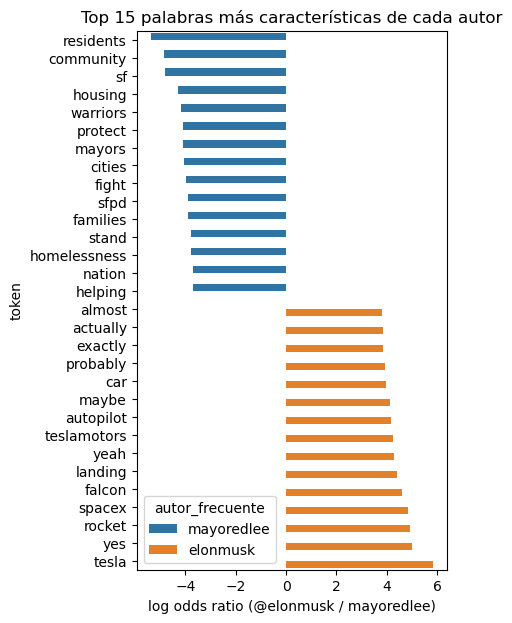

In [25]:
# Top 15 palabras más características de cada autor
# ==============================================================================

top_15 = tweets_logOdds[['log_odds', 'abs_log_odds', 'autor_frecuente']] \
        .groupby('autor_frecuente') \
        .apply(lambda x: x.nlargest(15, columns='abs_log_odds').reset_index()) \
        .reset_index(drop=True) \
        .sort_values('log_odds')

f, ax = plt.subplots(figsize=(4, 7))
sns.barplot(
    x    = 'log_odds',
    y    = 'token',
    hue  = 'autor_frecuente',
    data = top_15,
    ax   = ax
)
ax.set_title('Top 15 palabras más características de cada autor')
ax.set_xlabel('log odds ratio (@elonmusk / mayoredlee)');

Estas palabras posiblemente tendrán mucho peso a la hora de clasificar los tweets.

### Term Frequency e Inverse Document Frequency
Uno de los principales intereses en text mining, natural language processing e information retrieval es cuantificar la temática de un texto, así como la importancia de cada término que lo forma. Una manera sencilla de medir la importancia de un término dentro de un documento es utilizando la frecuencia con la que aparece (tf, term-frequency). Esta aproximación, aunque simple, tiene la limitación de atribuir mucha importancia a aquellas palabras que aparecen muchas veces aunque no aporten información selectiva. Por ejemplo, si la palabra matemáticas aparece 5 veces en un documento y la palabra página aparece 50, la segunda tendrá 10 veces más peso a pesar de que no aporte tanta información sobre la temática del documento. Para solucionar este problema se pueden ponderar los valores tf multiplicándolos por la inversa de la frecuencia con la que el término en cuestión aparece en el resto de documentos(idf). De esta forma, se consigue reducir el valor de aquellos términos que aparecen en muchos documentos y que, por lo tanto, no aportan información selectiva.

El estadístico tf-idf mide cómo de informativo es un término en un documento teniendo en cuenta la frecuencia con la que ese término aparece en otros documentos.

A continuación se muestra cómo calcular el valor tf-idf Sin embargo, en la práctica, es preferible utilizar implementaciones como TfidfVectorizer de Scikit Learn


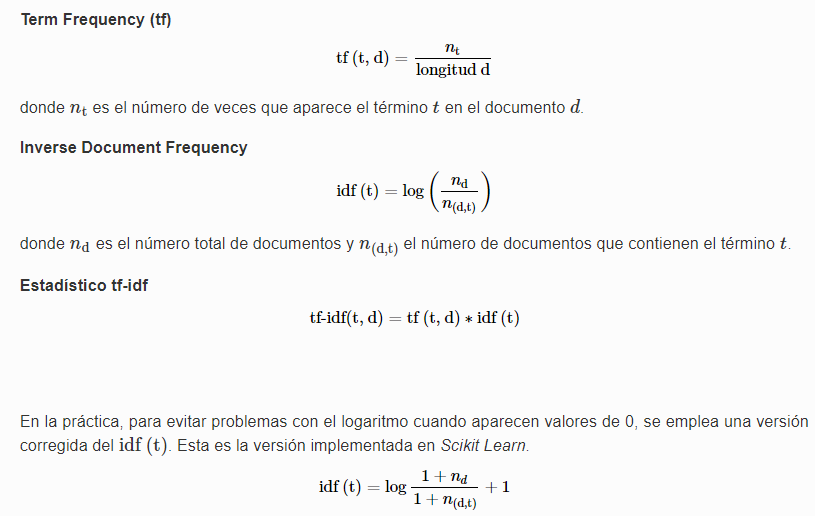

In [29]:
# Cálculo term-frecuency (tf)
# ==============================================================================
tf = tweets_tidy.copy()
# Número de veces que aparece cada término en cada tweet
tf = tf.groupby(["id", "token"])["token"].agg(["count"]).reset_index()
# Se añade una columna con el total de términos por tweet
tf['total_count'] = tf.groupby('id')['count'].transform(sum)
# Se calcula el tf
tf['tf'] = tf["count"] / tf["total_count"]
tf.sort_values(by = "tf",ascending=False).tail(10)

,id,token,count,total_count,tf
16275,5.609007e+17,traction,1,19,0.052632
16276,5.609007e+17,wheel,1,19,0.052632
42866,8.250489e+17,hq,1,19,0.052632
42867,8.250489e+17,hyperloop,1,19,0.052632
8166,3.546906e+17,walks,1,20,0.050000
8164,3.546906e+17,says,1,20,0.050000
8159,3.546906e+17,barman,1,20,0.050000
8158,3.546906e+17,bar,1,20,0.050000
8168,3.546906e+17,“yes,1,20,0.050000
8169,3.546906e+17,“you’d,1,20,0.050000


In [35]:
# Inverse document frequency
# ==============================================================================
idf = tweets_tidy.copy()
total_documents = idf["id"].drop_duplicates().count()
# Número de documentos (tweets) en los que aparece cada término
idf = idf.groupby(["token", "id"])["token"].agg(["count"]).reset_index()
idf['n_tweets_aparece'] = idf.groupby('token')['count'].transform(sum)
# Cálculo del idf
idf['idf'] = np.log(total_documents / idf['n_tweets_aparece'])
idf = idf[["token","n_tweets_aparece", "idf"]].drop_duplicates()
idf.sort_values(by="idf",ascending=False).tail(10)

,token,n_tweets_aparece,idf
65052,world,246,3.374280
41277,people,253,3.346222
47034,residents,264,3.303663
57300,tesla,272,3.273810
59086,today,272,3.273810
39584,one,273,3.270140
38284,new,295,3.192636
22823,great,327,3.089651
8724,city,355,3.007494
50471,sf,914,2.061781


In [28]:
# Term Frequency - Inverse Document Frequency
# ==============================================================================
tf_idf = pd.merge(left=tf, right=idf, on="token")
tf_idf["tf_idf"] = tf_idf["tf"] * tf_idf["idf"]
tf_idf.sort_values(by="id").tail()

,id,token,count,total_count,tf,n_documentos,idf,tf_idf
21767,9.287568e+17,dedicated,1,12,0.083333,24,5.701558,0.475130
64375,9.287568e+17,tents,1,12,0.083333,17,6.046398,0.503867
50030,9.287568e+17,stable,1,12,0.083333,12,6.394705,0.532892
7872,9.287568e+17,thank,1,12,0.083333,119,4.100488,0.341707
66741,9.287568e+17,livin…,1,12,0.083333,1,8.879612,0.739968


Puede observarse que para el primer tweet (id = 1.195196e+17), todos los términos que aparecen una vez, tienen el mismo valor de tf, sin embargo, dado que no todos los términos aparecen con la misma frecuencia en el conjunto de todos los tweets, la corrección de idf es distinta para cada uno.

De nuevo remarcar que, si bien se ha realizado el cálculo de forma manual con fines ilustrativos, en la práctica, es preferible utilizar implementaciones optimizadas como es el caso de la clase TfidfVectorizer de Scikit Learn.

# Clasificación de tweets
